#         IBM Data Science Professional Certificate Capstone Project 

#                              The Battle of Neighborhoods

## Introduction: Business Problem <a name="introduction"></a>

With a population of approximately 15 million people in the metropolitan area, Istanbul is one of the world's fourteenth largest city and one of the most populous cities in the world.

Despite such a crowded city, vegetarian or vegan individuals may find it difficult to find vegetarian or vegan restaurants in Istanbul. Turkish food culture is predominantly meat and meat products. For this reason, vegetarianism and veganism have not yet played an important role in Turkish culture.
    
In this project, 38 districts of Istanbul and vegetarian and vegan restaurants were found within 1km (thought to be walking distance) from the center. At the same time, a clustering analysis was performed with k-means by using the populations of the districts of Istanbul and the information of the restaurants in these districts.

The questions we want to answer at the end of the project are:
- Which districts in Istanbul have vegetarian or vegan restaurants?
- What are the number of restaurants by district?
- What are the popular districts for someone who wants to open a new restaurant, taking into account district populations and restaurant numbers?

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of existing restaurants in the borough (vegetarian or vegan)
* population of borough
* which boroughs have restaurants 

Following data sources will be needed to extract/generate the required information:

The dataset which can be reached at https://geo.nyu.edu/catalog/stanford-nj696zj1674, contains all the cities and borough lists of Turkey and information on the location of these cities and towns. 

Total population, female and male population percentages data of all these boroughs to the boroughs data. We can access the population data for 2018 borougs at https://www.nufusu.com/ilceleri/istanbul-ilceleri-nufusu.




- Using <b>Geopy</b> web service, location information of Istanbul was obtained
- <b>Folium</b> and districts of Istanbul, restaurants in districts and clusters obtained as a result of k-means are shown on the map
- Population information was obtained from the website with <b>BeautifulSoup</b>
- Restaurant information around coordinates determined with <b>GoogleMaps Place API</b>

In [1]:
# import all libraries and packages

import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import folium

import requests

from bs4 import BeautifulSoup

from unidecode import unidecode

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


The codes that will be used for the GoogleMaps API and Foursuare API that we will use in the project are defined below.


In [2]:
# Google API key

google_api_key =  # your Google API Key

In [3]:
# Foursquare CLIENT_ID and CLIENT_SECRET

CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET =  # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


## Get borough, latitude and longitude values for Istanbul



The dataset which can be reached at https://geo.nyu.edu/catalog/stanford-nj696zj1674, contains all the cities and borough lists of Turkey and information on the location of these cities and towns. I have obtained only the data of Istanbul and its boroughs from this dataset using the codes below.


In [4]:
with open('stanford-nj696zj1674-geojson.json') as json_file:
    data = json.load(json_file)

In [5]:
locations = data['features']

In [6]:
column_names = [ 'Borough', 'Latitude', 'Longitude' ]
ist_data=pd.DataFrame(columns=column_names)

for each in locations:
    if each['properties']['name_1'] == 'Istanbul':
#        mah = each['geometry']['coordinates'][0][0]
        ilce = each['properties']['name_2']
#        il = each['properties']['name_1']
        long = (each['properties']['bbox'][0] + each['properties']['bbox'][2]) / 2 
        lat = (each['properties']['bbox'][1] + each['properties']['bbox'][3]) / 2 
        
        
        ist_data = ist_data.append({ 'Borough': ilce, 'Latitude':lat, 'Longitude':long},
                                    ignore_index=True)

In [7]:
def replace_wrong_ch(df):
    
    new = df.replace(to_replace ="Çekmekoy", value ="Çekmeköy") 
    new = new.replace(to_replace ="Arnavutkoy", value ="Arnavutköy") 
    new = new.replace(to_replace ="Atasehir", value ="Ataşehir") 
    new = new.replace(to_replace ="Basaksehir", value ="Başakşehir")
    new = new.replace(to_replace ="Beylikduzu", value ="Beylikdüzü")
    new = new.replace(to_replace ="Eyüp", value ="Eyüpsultan") 
    
    return new

In [8]:
ist_data = replace_wrong_ch(ist_data)

In [9]:
ist_data.shape
print('Istanbul has 38 boroughs, so shape of ist_data is {}.'.format(ist_data.shape))

Istanbul has 38 boroughs, so shape of ist_data is (38, 3).


In [10]:
ist_data.head()

,Borough,Latitude,Longitude
0,Çatalca,41.302761,28.384248
1,Çekmeköy,41.079035,29.260164
2,Adalar,40.866249,29.058751
3,Ümraniye,41.039030,29.129102
4,Üsküdar,41.157230,28.571349



## Get latitude and longitude values for Istanbul city center and create a map with all boroughs



Using the Geopy web service, the location of Istanbul was obtained and then Folium and the districts of Istanbul were shown on the map.


In [11]:
# get latitude and longitude for İstanbul

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Istanbul'

geolocator = Nominatim(user_agent="ist_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Istanbul are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Istanbul are 41.0096334, 28.9651646.


In [12]:
# create map of İstanbul using latitude and longitude values

map_ist = folium.Map(location=[latitude, longitude], zoom_start=9)

# add markers to map
for borough, lat, lng in zip(ist_data['Borough'], ist_data['Latitude'], ist_data['Longitude']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#3154bb',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ist)  
    
map_ist



## Add population data to İstanbul's boroughs data




We can add the total population, female and male population percentages data of all these boroughs to the boroughs data. We can access the population data for 2018 borougs at https://www.nufusu.com/ilceleri/istanbul-ilceleri-nufusu.

The BeautifulSoup library was used to extract the data from the linkspecified. Population data and the codes used to obtain this data are available below.


In [13]:
# define the url
website_url = requests.get("https://www.nufusu.com/ilceleri/istanbul-ilceleri-nufusu").text

soup = BeautifulSoup(website_url,"lxml")

# get the table contains data
table = soup.find("table",{"class":"pure-table pure-table-bordered pure-table-striped"})
table_rows = table.find_all('tr')

# get all tha data from table rows
res = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
        
# create a dataframe includes all the data from res 
df = pd.DataFrame(res, columns=["Year", "Borough", "Population", "Male_Population", "Female_Population", "Male", "Female"])

# create a dataframe with the data to use
population_data = df[["Borough", "Population", "Male", "Female"]]

In [14]:
population_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 4 columns):
Borough       39 non-null object
Population    39 non-null object
Male          39 non-null object
Female        39 non-null object
dtypes: object(4)
memory usage: 1.3+ KB


In [15]:
population_data['Population'] = pd.to_numeric(population_data['Population'])

/home/funda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
population_data.head()

,Borough,Population,Male,Female
0,Esenyurt,891.120,"%51,23","%48,77"
1,Küçükçekmece,770.317,"%50,00","%50,00"
2,Bağcılar,734.369,"%50,70","%49,30"
3,Pendik,693.599,"%50,50","%49,50"
4,Ümraniye,690.193,"%50,06","%49,94"


In [17]:
population_data.shape

(39, 4)



### Merge ist_data with population_data



Ist_data contains data of Istanbul boroughs and population_data contains population were combined.

In [18]:
new_data = pd.merge(ist_data, population_data, on="Borough", how='left')

In [19]:
new_data.shape

(38, 6)

In [20]:
new_data

,Borough,Latitude,Longitude,Population,Male,Female
0,Çatalca,41.302761,28.384248,72.966,"%51,63","%48,37"
1,Çekmeköy,41.079035,29.260164,251.937,"%50,15","%49,85"
2,Adalar,40.866249,29.058751,16.119,"%53,37","%46,63"
3,Ümraniye,41.039030,29.129102,690.193,"%50,06","%49,94"
4,Üsküdar,41.157230,28.571349,529.145,"%48,73","%51,27"
5,Arnavutköy,41.237003,28.691689,270.549,"%51,99","%48,01"
6,Ataşehir,41.000820,29.128503,416.318,"%48,93","%51,07"
7,Avcılar,41.032429,28.727993,435.625,"%49,96","%50,04"
8,Şişli,41.095581,28.988744,274.289,"%48,67","%51,33"
9,Şile,41.110001,29.606633,36.516,"%51,50","%48,50"




## Get Venues in Each Borough with GoogleMapsAPI




With the GoogleMaps Place API, the getVenuesgoogle () function was created to find restaurants in all districts of Istanbul, 1 km from district centers. With the keyword parameter given to this function, each district was questioned separately for vegetarian and vegan restaurants.



In [21]:
def getVenuesgoogle(names, latitudes, longitudes, keyword, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):     
        
        url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json?location={},{}&radius={}&type=restaurant&keyword={}&key={}".format(
            lat,
            lng,
            radius,
            keyword,
            google_api_key)
        
        response = requests.get(url)
        json_data = json.loads(response.text)
        features=json_data['results']
    
        venues_list.append([(
            name, 
            lat, 
            lng, 
            f['name'], 
            f['geometry']['location']['lat'], 
            f['geometry']['location']['lng']) for f in features])

    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude']
    
    return(nearby_venues) 

In [22]:
ist_vegetarian_venues = getVenuesgoogle(names=new_data['Borough'],
                                   latitudes=new_data['Latitude'],
                                   longitudes=new_data['Longitude'], keyword = 'vegeterian')

In [23]:
ist_vegetarian_venues.shape

(197, 6)

In [24]:
ist_vegetarian_venues.head()

,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
0,Ümraniye,41.039030,29.129102,Arşiv Türk Mutfağı,41.027887,29.115766
1,Arnavutköy,41.237003,28.691689,Doğa Kır Lokantası,41.233052,28.700637
2,Ataşehir,41.000820,29.128503,Tandoori Indian Restaurant,40.992404,29.118991
3,Ataşehir,41.000820,29.128503,ORA Atasehir,40.992605,29.121568
4,Ataşehir,41.000820,29.128503,kazandibi,41.002190,29.127087


In [25]:
ist_vegan_venues = getVenuesgoogle(names=new_data['Borough'],
                                   latitudes=new_data['Latitude'],
                                   longitudes=new_data['Longitude'], keyword = 'vegan')

In [26]:
ist_vegan_venues.shape

(34, 6)

In [27]:
ist_vegan_venues.head()

,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
0,Ataşehir,41.000820,29.128503,Tandoori Indian Restaurant,40.992404,29.118991
1,Ataşehir,41.000820,29.128503,Komagene,40.992252,29.117143
2,Ataşehir,41.000820,29.128503,Tatlises Cig Kofte,40.992088,29.119278
3,Ataşehir,41.000820,29.128503,Komagene,41.010686,29.140526
4,Bahçelievler,41.013857,28.837940,Komagene,41.005814,28.841443



Data from vegetarian and vegan restaurants combined.

ist_veg_venues = ist_vegetarian_venues + ist_vegan_venues


In [28]:
ist_veg_venues = pd.concat([ist_vegetarian_venues, ist_vegan_venues]).drop_duplicates('Venue Latitude').reset_index(drop=True)

In [29]:
ist_veg_venues.shape

(218, 6)

In [30]:
ist_veg_venues.head()

,Borough,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude
0,Ümraniye,41.039030,29.129102,Arşiv Türk Mutfağı,41.027887,29.115766
1,Arnavutköy,41.237003,28.691689,Doğa Kır Lokantası,41.233052,28.700637
2,Ataşehir,41.000820,29.128503,Tandoori Indian Restaurant,40.992404,29.118991
3,Ataşehir,41.000820,29.128503,ORA Atasehir,40.992605,29.121568
4,Ataşehir,41.000820,29.128503,kazandibi,41.002190,29.127087


In [31]:
# create a map with vegetarian and vegan venues

map_ist_veg_venues = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for venue, lat, lng in zip(ist_veg_venues['Venue'], ist_veg_venues['Venue Latitude'], ist_veg_venues['Venue Longitude']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='black',
        fill=True,
        fill_color='yellow',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ist_veg_venues)  
    
map_ist_veg_venues



## Finding Vegeterian and Vegan Restaurants in each Borough



In [32]:

venue = ist_veg_venues.groupby('Borough').count().reset_index()
print("Number of borough which contains Vegeterian and Vegan Restaurants are : ", len(venue))
new_data['Venue Count'] = venue['Venue']

new_data = new_data.fillna(0)

#new_data.sort_values(by=['Venue Count'], ascending=False)

Number of borough which contains Vegeterian and Vegan Restaurants are :  27


In [33]:
new_data.shape

(38, 7)

In [34]:
new_data.head()

,Borough,Latitude,Longitude,Population,Male,Female,Venue Count
0,Çatalca,41.302761,28.384248,72.966,"%51,63","%48,37",1.0
1,Çekmeköy,41.079035,29.260164,251.937,"%50,15","%49,85",20.0
2,Adalar,40.866249,29.058751,16.119,"%53,37","%46,63",8.0
3,Ümraniye,41.039030,29.129102,690.193,"%50,06","%49,94",1.0
4,Üsküdar,41.157230,28.571349,529.145,"%48,73","%51,27",11.0


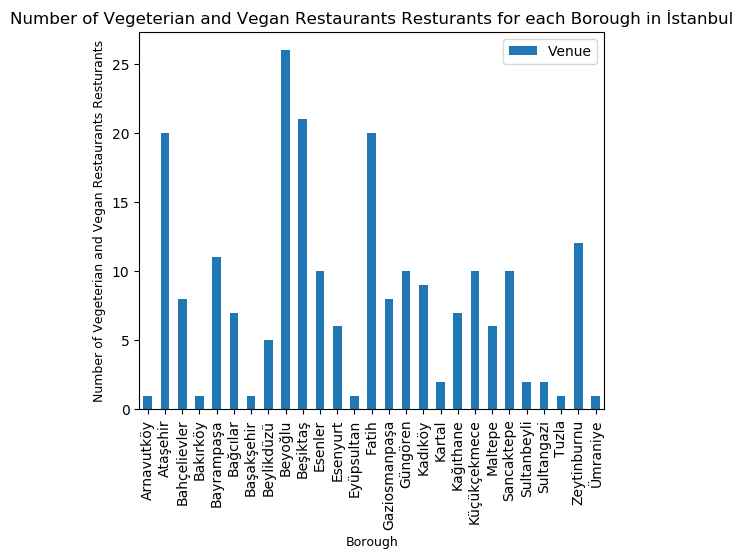

In [35]:
plt.figure(figsize=(6,5), dpi = 100)
# title
plt.title('Number of Vegeterian and Vegan Restaurants Resturants for each Borough in İstanbul')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 9)
#On y-axis
plt.ylabel('Number of Vegeterian and Vegan Restaurants Resturants', fontsize=9)
#giving a bar plot(
ist_veg_venues.groupby('Borough')['Venue'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()



## Analysis --- K-Means Clustering




Silhouette_score was used to find the best k value.


In [36]:
from sklearn.metrics import silhouette_score

X =  new_data[['Population', 'Venue Count']]

for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.5577802488064417
For n_clusters=3, The Silhouette Coefficient is 0.6140303115894824
For n_clusters=4, The Silhouette Coefficient is 0.6747169745086289
For n_clusters=5, The Silhouette Coefficient is 0.6255347291953213
For n_clusters=6, The Silhouette Coefficient is 0.6167575421420338
For n_clusters=7, The Silhouette Coefficient is 0.5937530116931746
For n_clusters=8, The Silhouette Coefficient is 0.5508853751257895
For n_clusters=9, The Silhouette Coefficient is 0.535901894382285
For n_clusters=10, The Silhouette Coefficient is 0.5423422958757351



The best value was 4 and the number of clusters was 4.


In [37]:
# set number of clusters
kclusters = 4

data = new_data[['Population', 'Venue Count']]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 2, 0, 3, 1, 2, 1, 1, 2, 0], dtype=int32)

In [38]:
new_data['Cluster'] = kmeans.labels_.astype(int)

In [39]:
new_data.head()

,Borough,Latitude,Longitude,Population,Male,Female,Venue Count,Cluster
0,Çatalca,41.302761,28.384248,72.966,"%51,63","%48,37",1.0,0
1,Çekmeköy,41.079035,29.260164,251.937,"%50,15","%49,85",20.0,2
2,Adalar,40.866249,29.058751,16.119,"%53,37","%46,63",8.0,0
3,Ümraniye,41.039030,29.129102,690.193,"%50,06","%49,94",1.0,3
4,Üsküdar,41.157230,28.571349,529.145,"%48,73","%51,27",11.0,1


In [40]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(new_data['Latitude'], new_data['Longitude'], new_data['Borough'], new_data['Cluster']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


## Each cluster


In [41]:
cluster0 = new_data.loc[new_data['Cluster'] == 0].sort_values(by=['Population'], ascending=False)

In [42]:
cluster0

,Borough,Latitude,Longitude,Population,Male,Female,Venue Count,Cluster
0,Çatalca,41.302761,28.384248,72.966,"%51,63","%48,37",1.0,0
9,Şile,41.110001,29.606633,36.516,"%51,50","%48,50",21.0,0
2,Adalar,40.866249,29.058751,16.119,"%53,37","%46,63",8.0,0


In [43]:
cluster0['Venue Count'].sum()

30.0

In [44]:
cluster1 = new_data.loc[new_data['Cluster'] == 1].sort_values(by=['Population'], ascending=False)

In [45]:
cluster1

,Borough,Latitude,Longitude,Population,Male,Female,Venue Count,Cluster
12,Bahçelievler,41.013857,28.837940,594.053,"%50,19","%49,81",1.0,1
4,Üsküdar,41.157230,28.571349,529.145,"%48,73","%51,27",11.0,1
35,Sultangazi,41.119114,28.880093,523.765,"%50,91","%49,09",0.0,1
30,Maltepe,40.967037,29.125406,497.034,"%49,90","%50,10",0.0,1
25,Gaziosmanpaşa,41.073460,28.902994,487.046,"%50,20","%49,80",12.0,1
29,Kartal,40.933113,29.172101,461.155,"%49,45","%50,55",0.0,1
28,Kadıköy,40.996927,29.052033,458.638,"%45,15","%54,85",0.0,1
20,Esenler,41.063173,28.864680,444.561,"%51,16","%48,84",6.0,1
27,Kağıthane,41.078743,28.965152,437.026,"%50,36","%49,64",0.0,1
23,Fatih,41.015833,28.948515,436.539,"%50,65","%49,35",2.0,1


In [46]:
cluster1['Venue Count'].sum()

48.0

In [47]:
cluster2 = new_data.loc[new_data['Cluster'] == 2].sort_values(by=['Population'], ascending=False)

In [48]:
cluster2

,Borough,Latitude,Longitude,Population,Male,Female,Venue Count,Cluster
33,Sarıyer,41.172670,29.033916,342.503,"%49,43","%50,57",0.0,2
18,Beylikdüzü,40.990078,28.648150,331.525,"%48,83","%51,17",7.0,2
34,Sultanbeyli,40.985119,29.262158,327.798,"%51,18","%48,82",0.0,2
24,Güngören,41.024130,28.874270,289.331,"%50,44","%49,56",1.0,2
37,Zeytinburnu,41.008221,28.900549,284.935,"%49,85","%50,15",0.0,2
8,Şişli,41.095581,28.988744,274.289,"%48,67","%51,33",26.0,2
15,Bayrampaşa,41.057999,28.895801,271.073,"%50,14","%49,86",10.0,2
5,Arnavutköy,41.237003,28.691689,270.549,"%51,99","%48,01",7.0,2
36,Tuzla,40.918980,29.342224,255.468,"%51,03","%48,97",0.0,2
1,Çekmeköy,41.079035,29.260164,251.937,"%50,15","%49,85",20.0,2


In [49]:
cluster2['Venue Count'].sum()

122.0

In [50]:
cluster3 = new_data.loc[new_data['Cluster'] == 3].sort_values(by=['Population'], ascending=False)

In [51]:
cluster3

,Borough,Latitude,Longitude,Population,Male,Female,Venue Count,Cluster
21,Esenyurt,41.049681,28.674332,891.120,"%51,23","%48,77",10.0,3
26,Küçükçekmece,41.026489,28.780925,770.317,"%50,00","%50,00",1.0,3
11,Bağcılar,41.047117,28.840071,734.369,"%50,70","%49,30",6.0,3
31,Pendik,40.961180,29.334546,693.599,"%50,50","%49,50",0.0,3
3,Ümraniye,41.039030,29.129102,690.193,"%50,06","%49,94",1.0,3


In [52]:
cluster3['Venue Count'].sum()

18.0


## Results and Discussion



By using the location information of the districts for Istanbul, we obtained vegetarian and vegan restaurants and locations of these restaurants within 1 km from each district center.
Then, we created clusters with k-means by using the population information of Istanbul districts and the number of vegetarian and vegan restaurants in those regions.
As a result of the experiments, we observed that 4 clusters were formed:

    Cluster0: population between 16K and 72K, 30 venue
    Cluster1: population between 181K and 342K, 48 venues
    Cluster2: population between 383K and 594K, 121 venue
    Cluster3: population between 690K and 891K, 18 venue



## Conclusion


Questions that can be asked after these project:
- What is the best location in Istanbul for vegan or vegeteryan Cuisine?
- Which areas have potential vegan or vegetarian resturant?
- Which areas in İstanbul lack vegan or vegetarian?